<a href="https://colab.research.google.com/github/kimsooyoung/deep-reinforcement-learning-gymnasium/blob/main/monte-carlo/Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title
!pip install gymnasium

In [4]:
# @title

#define plot utils
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)

        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

Reference link from [offical Gymnasium website](https://gymnasium.farama.org/environments/toy_text/blackjack/)

In [5]:
import sys
import numpy as np
import gymnasium as gym
from collections import defaultdict

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [ ]:
env = gym.make('Blackjack-v1')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [ ]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print(f'state : {state} {len(state)}')
        if len(state) == 2:
          cur_state = state[0][0]
        else:
          cur_state = state[0]
        print(f'cur_state: {cur_state}')
        action = env.action_space.sample()
        state, reward, done, info,_ = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

state : ((6, 6, 0), {}) 2
cur_state: 6
state : (17, 6, 1) 3
cur_state: 17
End game! Reward:  1.0
You won :)

state : ((12, 7, 0), {}) 2
cur_state: 12
state : (15, 7, 0) 3
cur_state: 15
End game! Reward:  1.0
You won :)

state : ((8, 10, 0), {}) 2
cur_state: 8
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ **always sticks** if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy.

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [ ]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        # state[0][0] current sum value of player's cards.
        if len(state) == 2:
          cur_state = state[0]
        else:
          cur_state = state
        probs = [0.8, 0.2] if cur_state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info, _ = bj_env.step(action)
        # episode.append((state, action, reward))
        episode.append((cur_state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy.

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [ ]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((12, 6, 0), 1, 0.0), ((19, 6, 0), 0, 1.0)]
[((16, 5, 0), 0, 1.0)]
[((16, 10, 1), 1, 0.0), ((18, 10, 1), 1, 0.0), ((18, 10, 0), 1, -1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum_test = defaultdict(lambda: np.zeros(env.action_space.n))
    N_test = defaultdict(lambda: np.zeros(env.action_space.n))
    Q_test = defaultdict(lambda: np.zeros(env.action_space.n))

    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## TODO: complete the function

        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)

        # Case1. iterative reward calculation
        # ex) range(3-1,-1,-1) => 2 1 0
        # G_{i} = R_{i} + gamma * G_{i+1}
        prev_reward = 0.0
        for i in range(len(states)-1, -1, -1):
            if i == len(states)-1:
              prev_reward = rewards[i]
              returns_sum_test[states[i]][actions[i]] += prev_reward
            else:
              new_reward = rewards[i] + gamma * prev_reward
              # returns_sum_test[states[i]][actions[i]] += rewards[i] + gamma * returns_sum_test[states[i+1]][actions[i+1]]
              returns_sum_test[states[i]][actions[i]] += new_reward
              prev_reward = new_reward
            N_test[states[i]][actions[i]] += 1.0
            Q_test[states[i]][actions[i]] = returns_sum_test[states[i]][actions[i]] / N_test[states[i]][actions[i]]

        # Case2. pre-define discount rates
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])

        # update the sum of the returns, number of visits, and action-value
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]

    # Uncomment below lines if wanna compare two methods
    print(f'returns_sum Case1: {Q_test}')
    print(f'returns_sum Case2: {Q}')

    return Q_test

Validate two methods with iteration 100

In [ ]:
# test your code
Q = mc_prediction_q(env, 100, generate_episode_from_limit_stochastic, gamma=0.9)

returns_sum Case1: defaultdict(<function mc_prediction_q.<locals>.<lambda> at 0x7dd43805ce50>, {(21, 9, 0): array([1., 0.]), (11, 9, 0): array([0. , 0.9]), (17, 8, 0): array([ 0., -1.]), (7, 8, 0): array([ 0. , -0.9]), (12, 10, 0): array([ 0.        , -0.90333333]), (19, 7, 0): array([ 0., -1.]), (15, 10, 0): array([-1.  , -0.95]), (18, 10, 0): array([-1.        , -0.58571429]), (17, 1, 1): array([0., 0.]), (20, 10, 0): array([ 0.57142857, -1.        ]), (14, 1, 0): array([-1., -1.]), (17, 10, 0): array([ 0., -1.]), (7, 10, 0): array([ 0. , -0.9]), (16, 10, 0): array([-1.        , -0.36666667]), (15, 5, 0): array([ 0., -1.]), (14, 10, 0): array([ 0.        , -0.36666667]), (18, 2, 0): array([ 0., -1.]), (13, 1, 0): array([ 1., -1.]), (12, 3, 0): array([-1., -1.]), (17, 7, 0): array([ 0., -1.]), (16, 7, 0): array([ 0.  , -0.45]), (13, 10, 0): array([-1.,  0.]), (21, 2, 0): array([1., 0.]), (17, 2, 0): array([0. , 0.9]), (18, 7, 0): array([ 1., -1.]), (21, 10, 0): array([1., 0.]), (14, 4

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 200000/200000.returns_sum Case1: defaultdict(<function mc_prediction_q.<locals>.<lambda> at 0x7a951f8a57e0>, {(13, 10, 0): array([-0.61931421, -0.58050619]), (21, 6, 0): array([ 0.91173184, -1.        ]), (11, 6, 0): array([-0.12280702, -0.07379518]), (16, 9, 0): array([-0.5380117 , -0.62782486]), (12, 9, 0): array([-0.50530035, -0.49820014]), (15, 2, 0): array([-0.40974212, -0.57582418]), (20, 10, 0): array([ 0.43299875, -0.88352827]), (17, 10, 0): array([-0.49029126, -0.69743246]), (7, 10, 0): array([-0.6       , -0.53102907]), (17, 9, 0): array([-0.3933162 , -0.65785997]), (15, 9, 0): array([-0.5184136, -0.628    ]), (13, 3, 0): array([-0.125     , -0.49318996]), (21, 2, 1): array([ 0.99136691, -0.05813953]), (12, 10, 0): array([-0.59883297, -0.58272462]), (12, 10, 1): array([-0.60606061, -0.32214765]), (11, 7, 0): array([-0.48344371, -0.10089021]), (14, 5, 0): array([-0.14366197, -0.52459016]), (12, 5, 0): array([-0.14986376, -0.47528249]), (15, 5, 1): array([-0.12195122, -

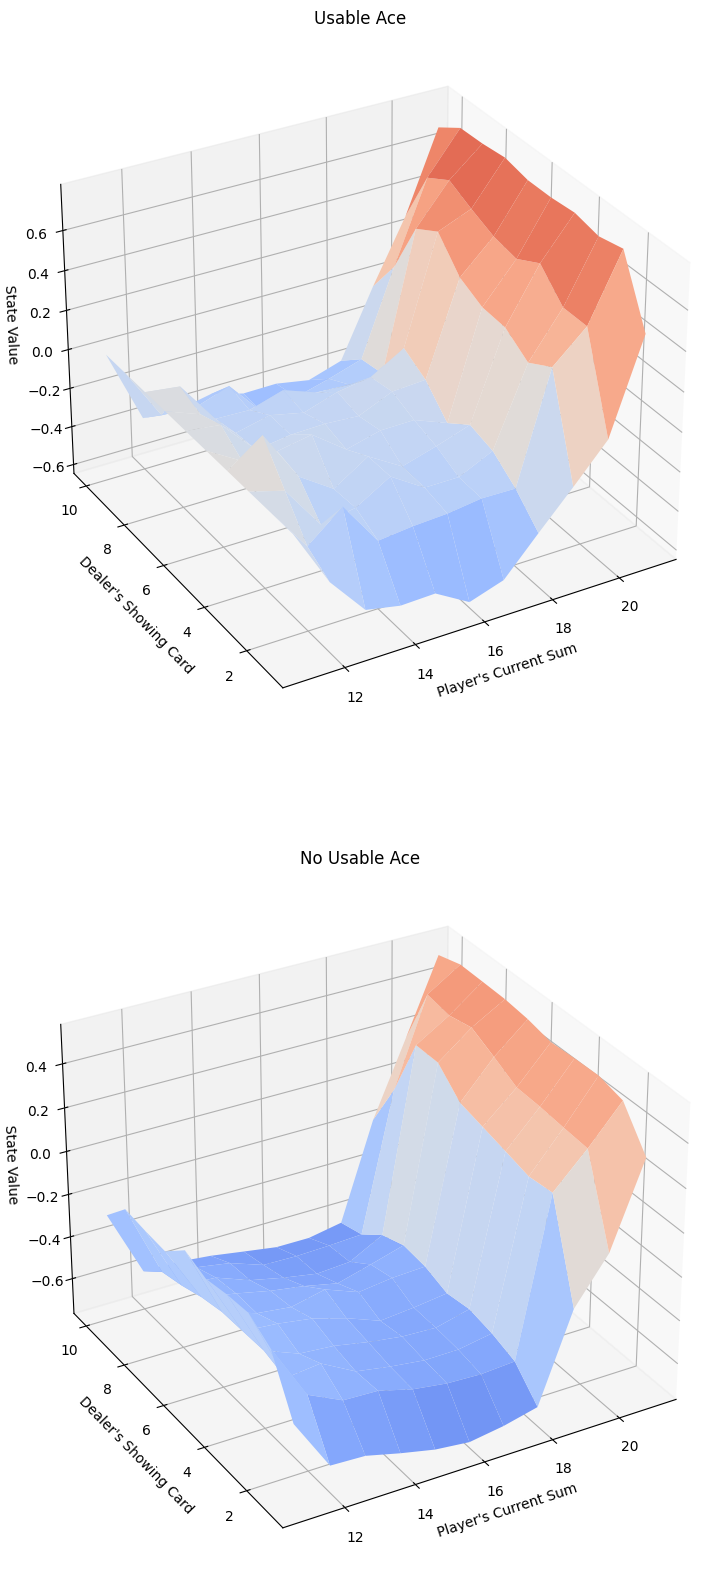

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k, (k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

1. generate_episode
2. greedy policy
3. Constant-alpha

In [6]:
import numpy as np

def get_prob(Q_cur, epsilon):
    A_s = len(Q_cur)
    output = np.ones(A_s) * epsilon / A_s
    best_action = np.argmax(Q_cur)
    output[best_action] = 1 - epsilon + epsilon / A_s
    return output

Implement Epsilon-Greedy Policies into `get_prob`.

$\pi(a|s) = \begin{cases}
1 - \epsilon + \frac{\epsilon}{A(s)}\\
\frac{\epsilon}{A(s)}
\end{cases} $

In [7]:
# test get_prob
Q_cur = np.array([0.6, 0.3])
epsilon = 0.9
output = get_prob(Q_cur, epsilon)
output

array([0.55, 0.45])

In [8]:
def generate_episode_from_constant_alpha(bj_env, Q, epsilon):
    episode = []
    state = bj_env.reset()
    while True:
        # state[0][0] current sum value of player's cards.
        if len(state) == 2:
          cur_state = state[0]
        else:
          cur_state = state

        # if first visit, don't need to adapt greedy policies
        if cur_state in Q:
          probs = get_prob(Q[cur_state], epsilon)
          action = np.random.choice(np.arange(2), p=probs)
        else:
          action = bj_env.action_space.sample()

        next_state, reward, done, info, _ = bj_env.step(action)
        episode.append((cur_state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [9]:
# test generate_episode_from_constant_alpha
bj_env = gym.make('Blackjack-v1')
Q = defaultdict(lambda: np.zeros(2))
epsilon = 0.9
output = generate_episode_from_constant_alpha(bj_env, Q, epsilon)
output

[((15, 7, 0), 1, -1.0)]

In [18]:
def mc_control(env, num_episodes, alpha, gamma=1.0, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.1):
    nA = env.action_space.n # 2
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    epsilon = epsilon_start
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ## TODO: complete the function

        # generate episode
        epsilon = max(epsilon_decay * epsilon, epsilon_min)
        episode = generate_episode_from_constant_alpha(env, Q, epsilon)

        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)

        # traverse episide
        discounted_reward = 0.0
        for i in range(len(states)-1, -1, -1):
            if i == len(states)-1:
              discounted_reward = rewards[i]
            else:
              discounted_reward = rewards[i] + gamma * discounted_reward

            old_Q = Q[states[i]][actions[i]]
            Q[states[i]][actions[i]] = old_Q + alpha * (discounted_reward - old_Q)

    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [19]:
# obtain the estimated optimal policy and action-value function
env = gym.make('Blackjack-v1')
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

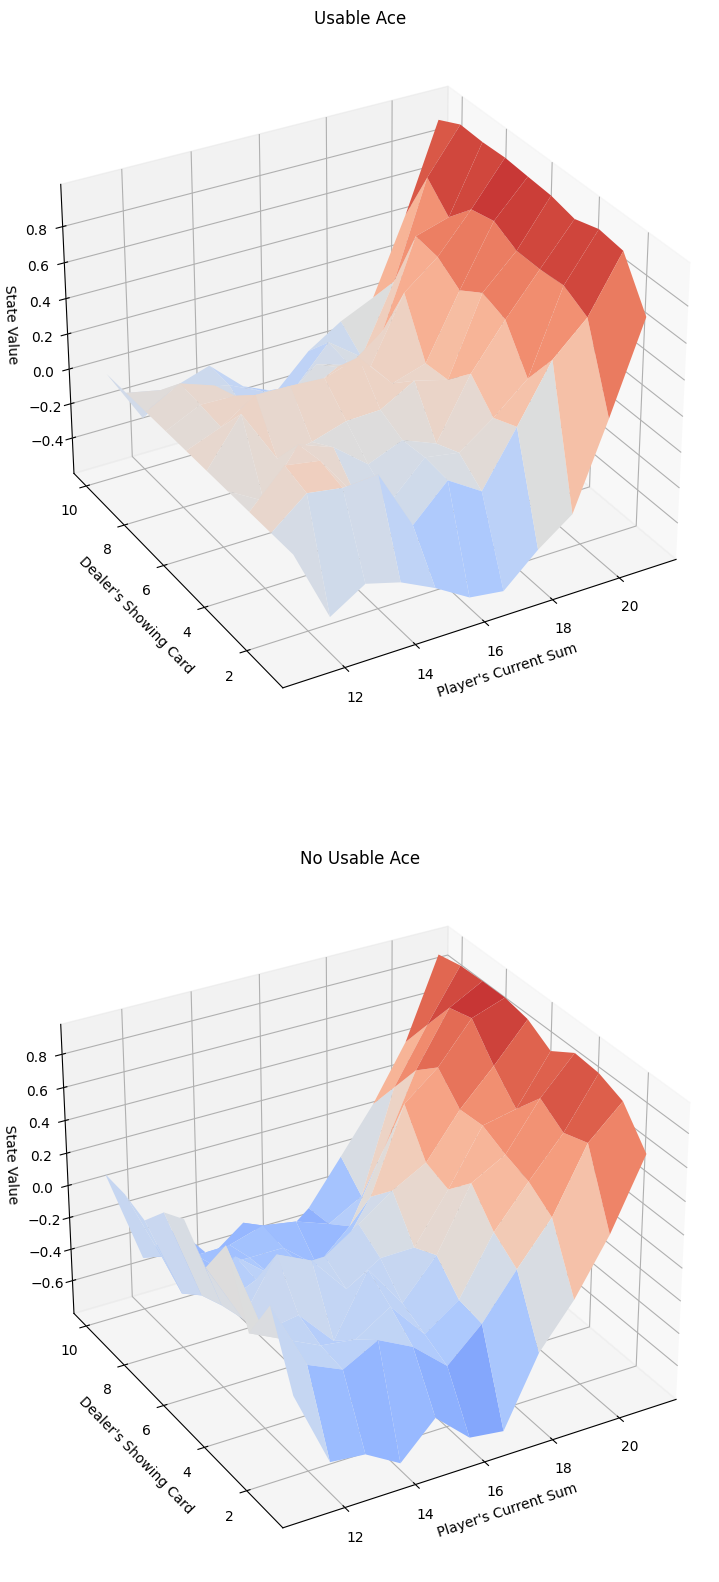

In [20]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

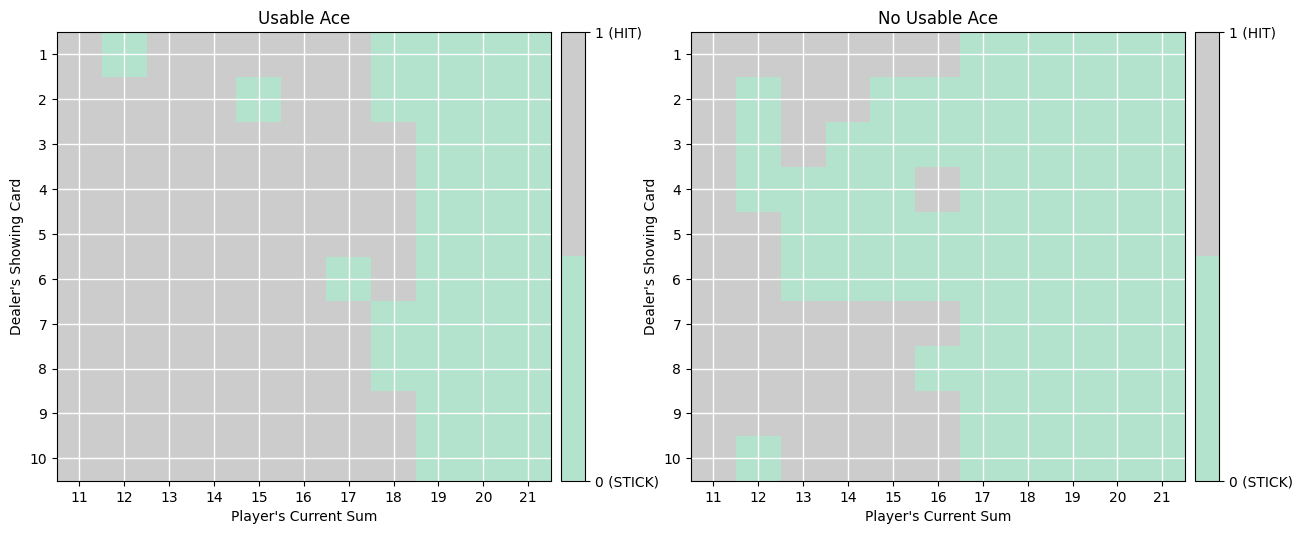

In [22]:
# plot the policy
plot_policy(policy)

**Answer from Udacity**


In [15]:
def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_constant_alpha(env, Q, epsilon)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Episode 500000/500000.

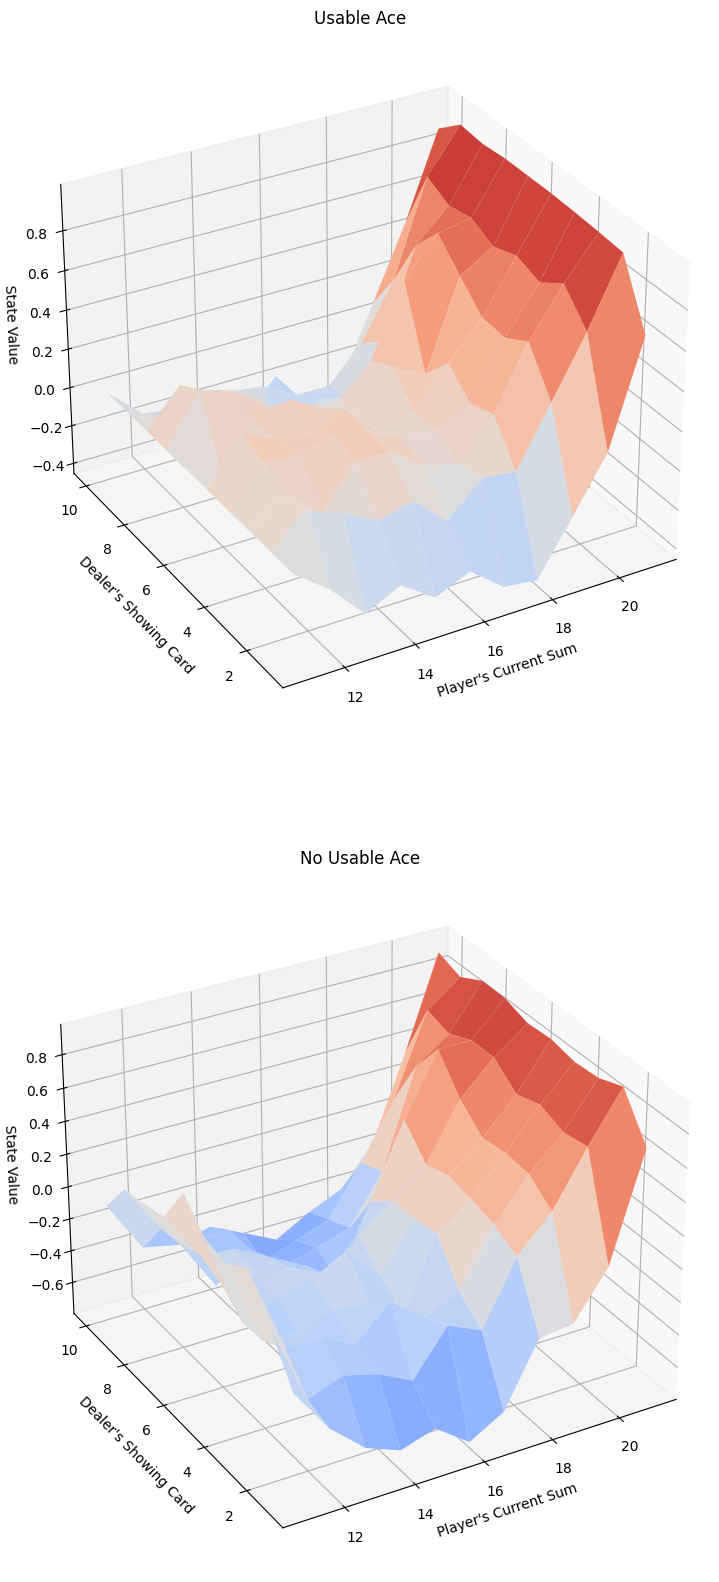

In [16]:
# obtain the estimated optimal policy and action-value function
env = gym.make('Blackjack-v1')
policy, Q = mc_control(env, 500000, 0.02)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

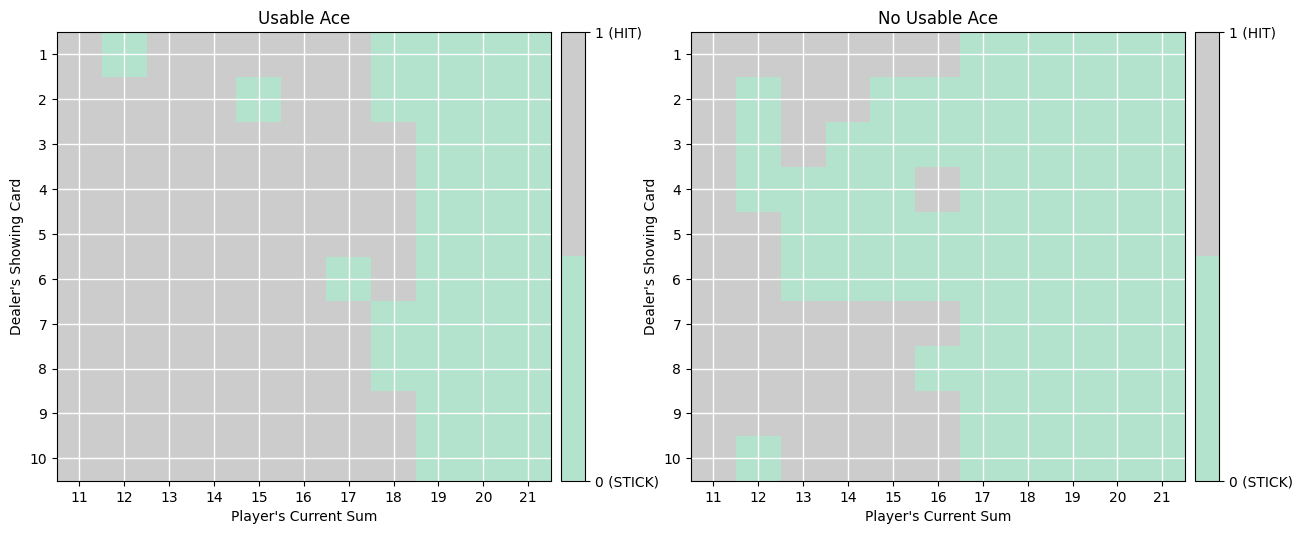

In [21]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorith|m, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/images/optimal.png?raw=1)